In [1]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler

sr = 16000
# sr = 24000

In [2]:

model = build_model(model_name="audioldm-m-full")

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internal

In [3]:
prompt = "A violin playing a heartfelt melody."
duration = 5.0  

In [4]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

Latent size for 5.0s: 128


Latent size for 5.0s: 128


DDIM Sampler: 100%|██████████| 200/200 [00:06<00:00, 31.75it/s]



Latent size for 5.0s: 128


DDIM Sampler: 100%|██████████| 200/200 [00:06<00:00, 31.75it/s]



Diffusion sampling took 6.309055805206299 seconds (0.03154527902603149s per step)


Latent size for 5.0s: 128


DDIM Sampler: 100%|██████████| 200/200 [00:06<00:00, 31.75it/s]



Diffusion sampling took 6.309055805206299 seconds (0.03154527902603149s per step)


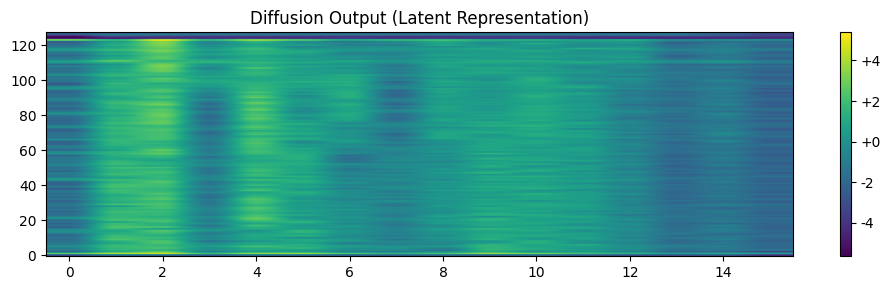

In [5]:

sampler = DDIMSampler(model)

from audioldm.pipeline import duration_to_latent_t_size
latent_size = duration_to_latent_t_size(duration)
print(f"Latent size for {duration}s: {latent_size}")

ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0

shape = [model.channels, latent_size, model.latent_f_size]
z = torch.randn([1] + shape).to(model.device)

start_time = time.time()
samples, _ = sampler.sample(
    S=ddim_steps,  
    batch_size=1,
    shape=shape,
    conditioning=text_emb,
    unconditional_conditioning=unconditional_embedding,
    unconditional_guidance_scale=unconditional_guidance_scale,
    eta=ddim_eta,
    verbose=False,
    x_T=z
)
diffusion_time = time.time() - start_time
print(f"Diffusion sampling took {diffusion_time} seconds ({diffusion_time/ddim_steps}s per step)")

plt.figure(figsize=(10, 3))
plt.imshow(samples[0, 0].detach().cpu().numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title('Diffusion Output (Latent Representation)')
plt.tight_layout()
plt.show()

# 5s 6
# 20s 31s
# 30s 62
# 80s 344s

VAE decoding took 0.03 seconds
Mel spectrogram shape: (1, 1, 512, 64)


VAE decoding took 0.03 seconds
Mel spectrogram shape: (1, 1, 512, 64)


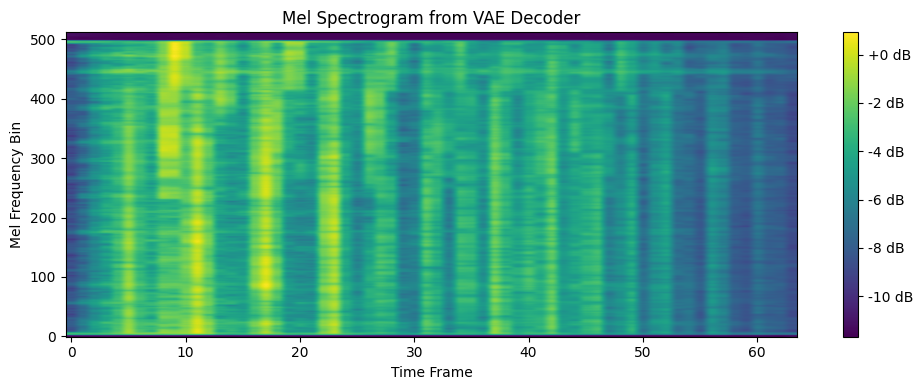

In [6]:

start_time = time.time()
mel_spectrogram = model.decode_first_stage(samples)
vae_time = time.time() - start_time
print(f"VAE decoding took {vae_time:.2f} seconds")

mel_spectrogram = mel_spectrogram.detach().cpu().numpy()
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")

plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0, 0], aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram from VAE Decoder')
plt.ylabel('Mel Frequency Bin')
plt.xlabel('Time Frame')
plt.tight_layout()
plt.show()

In [ ]:
mel_tensor = torch.from_numpy(mel_spectrogram).to(model.device)
print(f"Device: {model.device}")

# Reset peak memory stats and measure initial memory
torch.cuda.reset_peak_memory_stats(model.device)
torch.cuda.synchronize()
mem_before = torch.cuda.memory_allocated(model.device)
print(f"Memory before vocoder: {mem_before / (1024**2):.2f} MiB")

# Run vocoder
start_time = time.time()
waveform = model.mel_spectrogram_to_waveform(mel_tensor)[0]
torch.cuda.synchronize()  # Ensure all operations complete before timing
vocoder_time = time.time() - start_time

# Measure memory after vocoder and peak memory during vocoder
mem_after = torch.cuda.memory_allocated(model.device)
mem_peak = torch.cuda.max_memory_allocated(model.device)
print(f"Memory after vocoder: {mem_after / (1024**2):.2f} MiB")
print(f"Peak memory during vocoder: {mem_peak / (1024**2):.2f} MiB")
print(f"Memory used by vocoder: {(mem_after - mem_before) / (1024**2):.2f} MiB")
print(f"Vocoder processing took {vocoder_time:.4f} seconds")

ipd.display(ipd.Audio(waveform, rate=sr))

cuda:0
